Import the shapefile


In [26]:
import geopandas as gpd
phoenix_city = gpd.read_file(r"C:\Users\ekemi\Downloads\City_Limit_Light_Outline\City_Limit_Light_Outline.shp")


Import the data from OpenStreetMap

In [27]:

import osmnx as ox
from osmnx.features import features_from_place

place = "Phoenix, Arizona, USA"

tags = {
    'leisure': ['park', 'garden', 'golf_course'],
    'landuse': ['grass', 'recreation_ground'],
    'natural': ['wood', 'scrub']
}
green_spaces = ox.features_from_place(place, tags)
gdf = green_spaces


Create a map of Green space

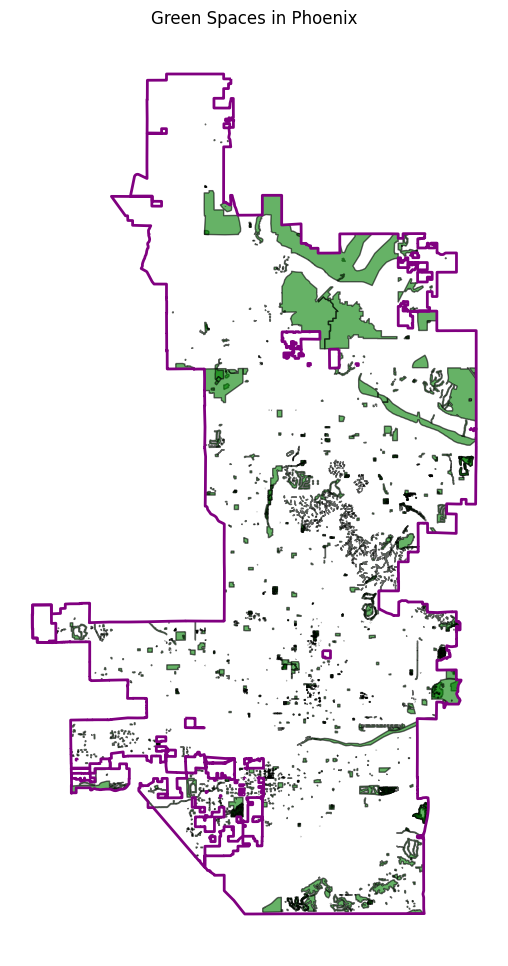

In [28]:
import matplotlib.pyplot as plt

green_spaces = green_spaces[green_spaces.geometry.type.isin(['Polygon', 'MultiPolygon'])]
green_spaces = green_spaces.to_crs(epsg=3857)

set(gdf.columns).intersection(set(phoenix_city.columns))
phoenix_city = phoenix_city[['geometry']]

import shapely
gdf = gdf[gdf.geometry.apply(lambda geom: isinstance(geom, (shapely.geometry.Polygon, shapely.geometry.MultiPolygon)))]
phoenix_city = phoenix_city.to_crs(gdf.crs)

gdf = gdf.reset_index(drop=True)
phoenix_city = phoenix_city.reset_index(drop=True)
gdf = gpd.overlay(gdf, phoenix_city, how='intersection')

base = gdf.plot(figsize=(12,12),color = 'green', legend=True, edgecolor='black', alpha=0.6)
phoenix_city.boundary.plot(ax = base, color = "purple", linewidth = 2) ## City of Phoenix's main color is purple
plt.title("Green Spaces in Phoenix")
plt.axis("off")
plt.savefig("green_spaces_phoenix.png", dpi=300, bbox_inches='tight')
plt.show()
##this was a pain to figure out. 


Import U.S. Census Bureau 

In [ ]:
import geopandas as gpd
income_gdf = gpd.read_file(r"C:\Users\ekemi\Documents\Project due Oct 10\MaricopaCountyIncomeMap.shp")
print(income_gdf.columns)
print(income_gdf.crs)
## Luckily I have an income map already saved on my computer!

## Match the crs
green_spaces = green_spaces.to_crs(epsg=3857)
## Spatial join
joined  = gpd.sjoin(green_spaces, income_gdf[['GEOID','MEDHINC_CY', 'geometry']], how='left', predicate='intersects')


Index(['MEDHINC_CY', 'Shape_Leng', 'Shape_Area', 'FID_', 'STATEFP', 'COUNTYFP',
       'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD',
       ...
       'MHIGRWCYFY', 'DIVINDX_FY', 'MEDHINC_FY', 'AVGHINC_FY', 'PCI_FY',
       'Shape__Are', 'Shape__Len', 'Shape_Le_2', 'Shape_Ar_2', 'geometry'],
      dtype='object', length=196)
EPSG:3857
                 GEOID  MEDHINC_CY
element  id                       
relation 1410003  None      112187
         1410003  None      133625
         1410003  None      138382
         1445633  None      102779
         1665559  None       57123


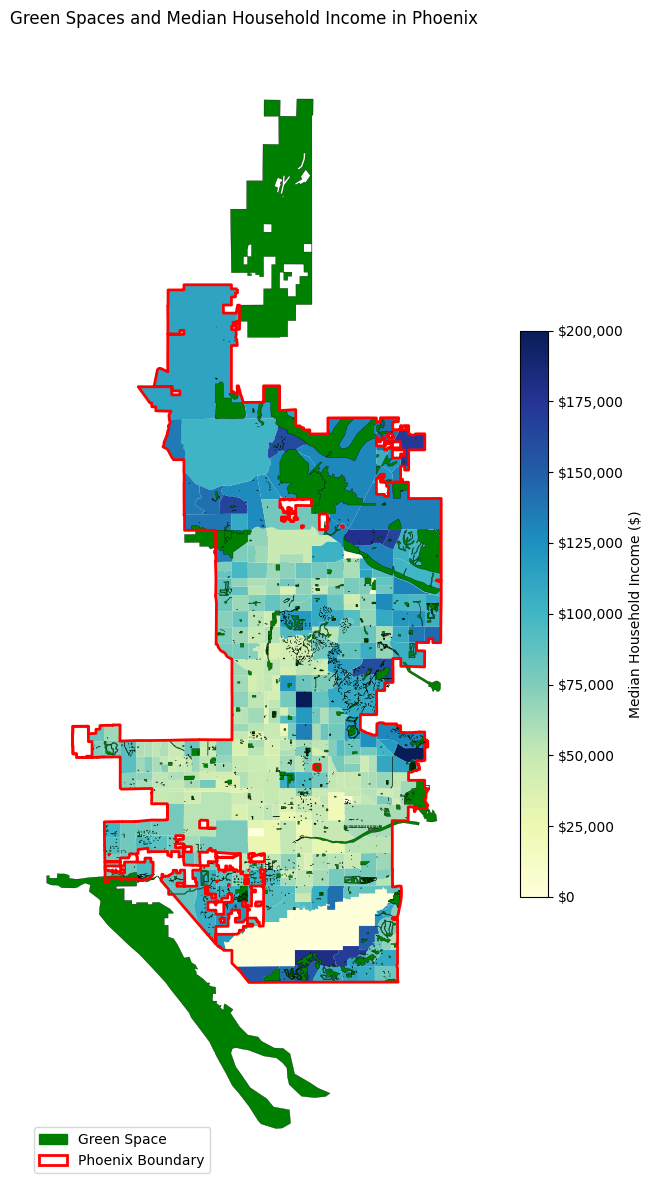

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

# Match CRS
phoenix_city_proj = phoenix_city.to_crs(income_gdf.crs)
income_clipped = gpd.clip(income_gdf, phoenix_city_proj)

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Plot MHHI as choropleth
income_plot = income_clipped.plot(
    column='MEDHINC_CY',
    cmap='YlGnBu',
    legend=True,
    ax=ax,
    edgecolor='none',
    legend_kwds={'label': "Median Household Income ($)", 'shrink': 0.5}
)

# Format colorbar with dollar symbols
colorbar = income_plot.get_figure().get_axes()[-1]
colorbar.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Overlay green spaces
green_spaces.plot(ax=ax, color='green', edgecolor='black', linewidth=0.2, label='Green Space')

# Overlay Phoenix city boundary
phoenix_city_proj.boundary.plot(ax=ax, color='red', linewidth=2, label='Phoenix Boundary')

# Add custom legend
green_patch = mpatches.Patch(color='green', label='Green Space')
boundary_patch = mpatches.Patch(edgecolor='red', facecolor='none', linewidth=2, label='Phoenix Boundary')
ax.legend(handles=[green_patch, boundary_patch], loc='lower left')

# Final touches
plt.title("Green Spaces and Median Household Income in Phoenix")
plt.axis("off")
plt.tight_layout()
plt.savefig("phoenix_greenspace_income_map.png", dpi=300, bbox_inches='tight')
plt.show()


Create buffers

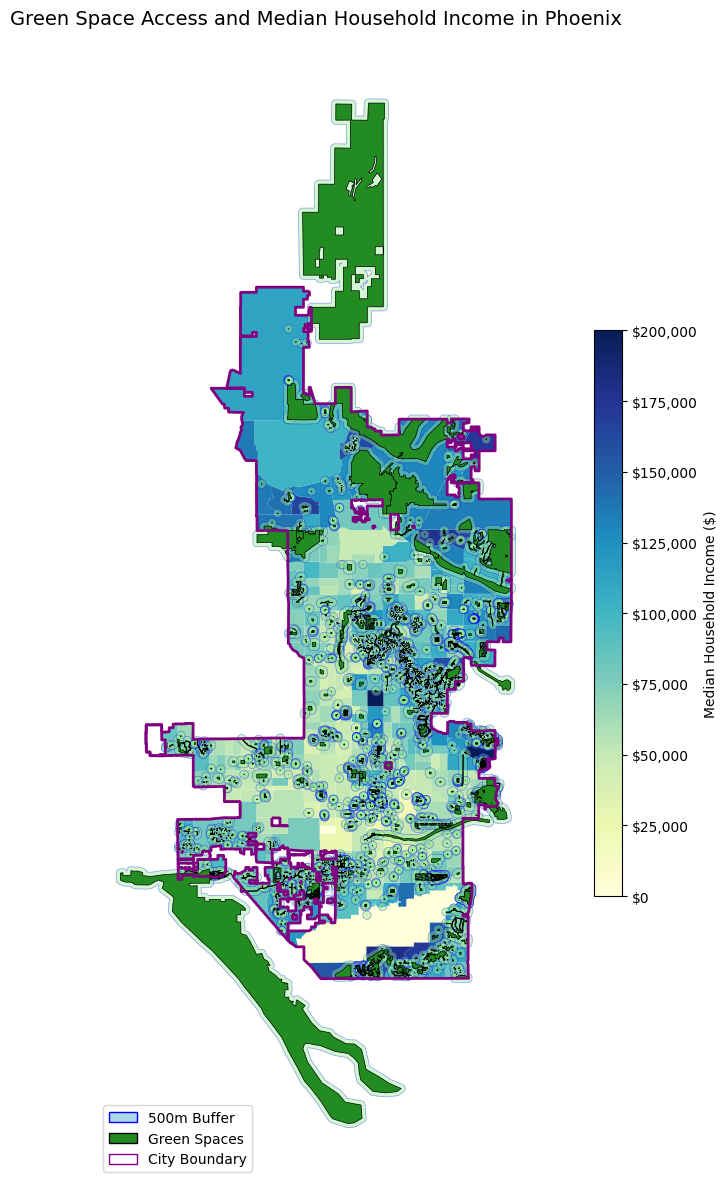

In [ ]:
# Set coordinate system
green_spaces = green_spaces.to_crs(epsg=3857)
phoenix_city = phoenix_city.to_crs(epsg=3857)
income_gdf = income_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))

# Plot MHHI 
income_clipped.plot(
    column='MEDHINC_CY',
    cmap='YlGnBu',
    ax=ax,
    edgecolor='none',
    legend_kwds={'label': "Median Household Income ($)", 'shrink': 0.5}
)
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=income_clipped['MEDHINC_CY'].min(), vmax=income_clipped['MEDHINC_CY'].max())
cmap = plt.cm.YlGnBu
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  


cbar = plt.colorbar(sm, ax=ax, shrink=0.5, label="Median Household Income ($)")
cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Plot 500m buffer
buffer_500.plot(ax=ax, color='lightgreen', alpha=0.4, edgecolor='blue', linewidth=0.5, label='500m Buffer')


green_spaces.plot(ax=ax, color='forestgreen', edgecolor='black', linewidth=0.5, label='Green Spaces')

#  Plot city boundary
phoenix_city.boundary.plot(ax=ax, color='purple', linewidth=2, label='Phoenix City Limits')


from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightblue', edgecolor='blue', label='500m Buffer'),
    Patch(facecolor='forestgreen', edgecolor='black', label='Green Spaces'),
    Patch(facecolor='none', edgecolor='purple', label='City Boundary')
]
ax.legend(handles=legend_elements, loc='lower left')

plt.title("Green Space Access and Median Household Income in Phoenix", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.savefig("mhhi_buffer_overlay_map.png", dpi=300, bbox_inches='tight')
plt.show()